In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from obspy.signal.filter import lowpass
import os
from pathlib import Path

import pyarrow as pa
import pyarrow.parquet as pq
import json

from scipy import signal
from obspy.signal.tf_misfit import cwt
import pywt
from scipy import stats
        
from multiprocessing import Pool, cpu_count
from generate_ts_utils import *

In [2]:
fsize = 15
tsize = 18
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = fsize-3
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

In [3]:
class vel_ts:
    def __init__(self, array):
        self.array = array
        self.record_number= self.array[0][0]
        #self.meta_dict=make_meta_dict(self.array)

        
    def vel_load_ds(self, target_sr):
        
        path = Path(os.getcwd())
       
        print(glob.glob(os.path.join(path.parent.absolute(),'data','ngaw2','RSN%s_*.VT2' %self.record_number)))
        sm_fn=glob.glob(os.path.join(path.parent.absolute(),'data','ngaw2','RSN%s_*.VT2' %self.record_number))

        scale_f, dt= meta_check(sm_fn[0])

        # determine vertical TS
        up_idx=vertical_idx(sm_fn)

        #sort out components- only distinguish between Vert and Horiz for gnss noise
        h_idxs=np.delete(np.arange(3),up_idx)
        h0_idx=h_idxs[0]
        h1_idx=h_idxs[1]

        sr=1/dt
        deci=int(sr/target_sr)
        
        self.H0, self.time, self.H0_y=load_ds_label(sm_fn[h0_idx],sr, deci, buffer45=True)
        self.H1, self.time, self.H1_y=load_ds_label(sm_fn[h1_idx],sr, deci, buffer45=True)
        self.UP, self.time, self.UP_y=load_ds_label(sm_fn[up_idx],sr, deci, buffer45=True)
        
def generate_gnss_ts(nga_event_station):
    vel_1=vel_ts(nga_event_station)
    target_sr=5
    vel_1.vel_load_ds(target_sr)

    for noise_lev in np.arange(5,100,15):
        store_df_li=[]
        samples2add=np.random.randint(0,60*5)
        for name,ts,ts_labels in zip(['H0','H1','UP'],[vel_1.H0,vel_1.H1,vel_1.UP],[vel_1.H0_y,vel_1.H1_y,vel_1.UP_y]):
            #add random buffer
            ts,t=add_random_buffer(ts, vel_1.time, samples2add,target_sr)
            ts_labels=np.concatenate((np.zeros(samples2add) ,ts_labels))
            noise_ts=create_noise_ts(n_steps=len(t), level=noise_lev, name=name)
            combined=ts+noise_ts
            #import pandas as pd
            store_df=pd.DataFrame(np.vstack((t,combined, noise_ts, ts_labels.astype(int))).transpose(), 
                            columns=['t','%s_ts' %name,'%s_noise'%name, '%s_label' %name])

            store_df.set_index('t', inplace=True)
            store_df_li.append(store_df)
        write_to_pq(store_df_li, vel_1.array, noise_lev)
        

In [4]:
create_nga_event_station_list(rsn=4369)

[[4369,
  ' "Umbria Marche (aftershock 1)_ Italy"',
  1997,
  ' "Nocera Umbra-Salmata"',
  5.5,
  ' Normal',
  11.72,
  12.45,
  694.0]]

In [3]:
vel_1=vel_ts(create_nga_event_station_list(rsn=4369))
target_sr=5
vel_1.vel_load_ds(target_sr)
name='H0'
noise_lev=50
noise_ts=create_noise_ts(n_steps=len(vel_1.H0), level=noise_lev, name=name)

['/home/ec2-user/pgv_ml/synth_gnss_vel/data/ngaw2/RSN4369_UBMARCHE.P_E-NCM-DN.VT2', '/home/ec2-user/pgv_ml/synth_gnss_vel/data/ngaw2/RSN4369_UBMARCHE.P_E-NCM000.VT2', '/home/ec2-user/pgv_ml/synth_gnss_vel/data/ngaw2/RSN4369_UBMARCHE.P_E-NCM270.VT2']


In [5]:
noise_ts_array=[]
for i,noise_lev in enumerate([10,90]):
    name='H0'
    
    noise_ts_array.append(create_noise_ts(n_steps=len(vel_1.H0), level=noise_lev, name=name))

/tmp/ipykernel_11927/4016118557.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ax[i,1].loglog(1/f_sig, p_sig, label='signal', color='#d95f02')
/tmp/ipykernel_11927/4016118557.py:27: RuntimeWarning: divide by zero encountered in true_divide
  ax[i,1].loglog(1/f_noi, p_noi, label='noise', color='#1b9e77')
/tmp/ipykernel_11927/4016118557.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ax[i,1].loglog(1/f_sig, p_sig, label='signal', color='#d95f02')
/tmp/ipykernel_11927/4016118557.py:27: RuntimeWarning: divide by zero encountered in true_divide
  ax[i,1].loglog(1/f_noi, p_noi, label='noise', color='#1b9e77')


Text(0.5, 1.0, 'time-freq domain')

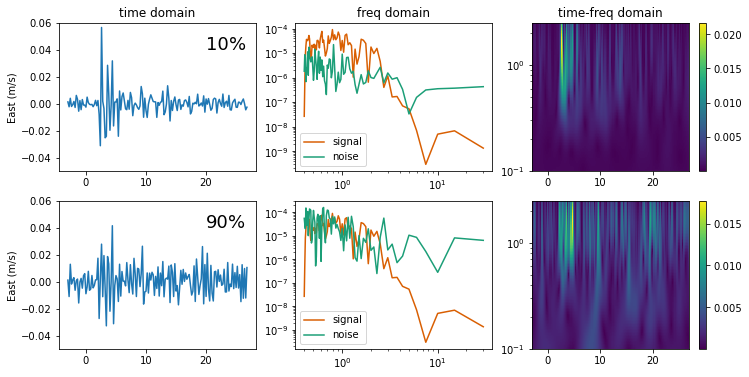

In [6]:



idx=60+150
idx2=idx+5*30
fig,ax=plt.subplots(2,3, figsize=(12,6))


    
    
for i,noise_lev in enumerate([10,90]):
    
    
    noise_ts=noise_ts_array[i]
    combined=vel_1.H0+noise_ts
        
    ax[i,0].plot(vel_1.time[idx:idx2],combined[idx:idx2])
    #ax[i].plot(vel_1.time[idx:idx2],vel_1.H0[idx:idx2])
    ax[i,0].set_ylim([-.05,.06])
    ax[i,0].set_ylabel('East (m/s)')
    ax[i,0].text(20, .04, '%s%%' %noise_lev, fontsize=18)
    
    f,p=signal.periodogram(combined[idx:idx2],fs=5)
    #ax[i,2].loglog(1/f, p, label='noise+signal', color='#7570b3')
    
    f_sig,p_sig=signal.periodogram(vel_1.H0[idx:idx2],fs=5)
    ax[i,1].loglog(1/f_sig, p_sig, label='signal', color='#d95f02')
    
    f_noi,p_noi=signal.periodogram(noise_ts[idx:idx2],fs=5)
    ax[i,1].loglog(1/f_noi, p_noi, label='noise', color='#1b9e77')
    ax[i,1].legend(loc='lower left')
    
    
    per_min=.4
    per_max=10
    f_min = 1/per_max
    f_max = 1/per_min
    
    dt=.2
    scalogram = cwt(combined[idx:idx2], dt, 1, f_min, f_max)


    x, y = np.meshgrid(
        vel_1.time[idx:idx2],
        np.logspace(np.log10(f_min), np.log10(f_max), scalogram.shape[0]))

    #cmap=obspy_sequential
    cmap=plt.get_cmap('viridis')
    im=ax[i,2].pcolormesh(x, y, np.abs(scalogram), cmap=cmap)#obspy_sequential)
    #ax.set_xlabel("Time after %s [s]" % tr.stats.starttime)
    #ax[i,3].set_ylabel("Frequency [Hz]")
    #ax[i,3].set_xlabel("Time since OT [S]")
    fig.colorbar(im, ax=ax[i,2])
    ax[i,2].set_yscale('log')
    ax[i,2].set_ylim(f_min, f_max)
ax[0,0].set_title('time domain')
ax[0,1].set_title('freq domain')
ax[0,2].set_title('time-freq domain')
#plt.savefig('wavelet_metric.png', dpi=300)

(-0.04, 0.06)

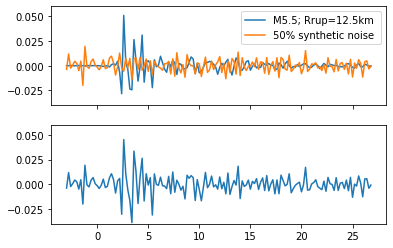

In [30]:
idx=60+150
idx2=idx+5*30
name='H0'
noise_lev=50

ax_lim=[-.04,.06]
fig,ax=plt.subplots(2,1, sharex=True)
ax[0].plot(vel_1.time[idx:idx2],vel_1.H0[idx:idx2], label='M5.5; Rrup=12.5km ')
ax[0].set_ylim(ax_lim)

noise_ts=create_noise_ts(n_steps=len(vel_1.H0), level=noise_lev, name=name)
ax[0].plot(vel_1.time[idx:idx2],noise_ts[idx:idx2], label='50% synthetic noise')
#ax[0].set_ylim(ax_lim)
ax[0].legend()

combined=vel_1.H0+noise_ts
ax[1].plot(vel_1.time[idx:idx2],combined[idx:idx2])
ax[1].set_ylim(ax_lim)

In [142]:
vel_1.time[vel_1.H0_y>0]

array([  1.2,   1.4,   1.6,   1.8,   2. ,   2.2,   2.4,   2.6,   2.8,
         3. ,   3.2,   3.4,   3.6,   3.8,   4. ,   4.2,   4.4,   4.6,
         4.8,   5. ,   5.2,   5.4,   5.6,   5.8,   6. ,   6.2,   6.4,
         6.6,   6.8,   7. ,   7.2,   7.4,   7.6,   7.8,   8. ,   8.2,
         8.4,   8.6,   8.8,   9. ,   9.2,   9.4,   9.6,   9.8,  10. ,
        10.2,  10.4,  10.6,  10.8,  11. ,  11.2,  11.4,  11.6,  11.8,
        12. ,  12.2,  12.4,  12.6,  12.8,  13. ,  13.2,  13.4,  13.6,
        13.8,  14. ,  14.2,  14.4,  14.6,  14.8,  15. ,  15.2,  15.4,
        15.6,  15.8,  16. ,  16.2,  16.4,  16.6,  16.8,  17. ,  17.2,
        17.4,  17.6,  17.8,  18. ,  18.2,  18.4,  18.6,  18.8,  19. ,
        19.2,  19.4,  19.6,  19.8,  20. ,  20.2,  20.4])

/tmp/ipykernel_11927/4195333844.py:56: RuntimeWarning: divide by zero encountered in true_divide
  ax4.loglog(1/f, p_sig, label='signal', color=colors[0], alpha=.5)
/tmp/ipykernel_11927/4195333844.py:57: RuntimeWarning: divide by zero encountered in true_divide
  ax4.loglog(1/f, p_noise, label='noise', color=colors[1], alpha=.5)
/tmp/ipykernel_11927/4195333844.py:58: RuntimeWarning: divide by zero encountered in true_divide
  ax4.loglog(1/f, p_comb, label='combined', color=colors[2], lw=2)
/tmp/ipykernel_11927/4195333844.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('demonstrate.png',dpi=300)
/tmp/ipykernel_11927/4195333844.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('demonstrate.png',dpi=300)
/home/ec2-user/miniconda3/envs/snivel/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This f

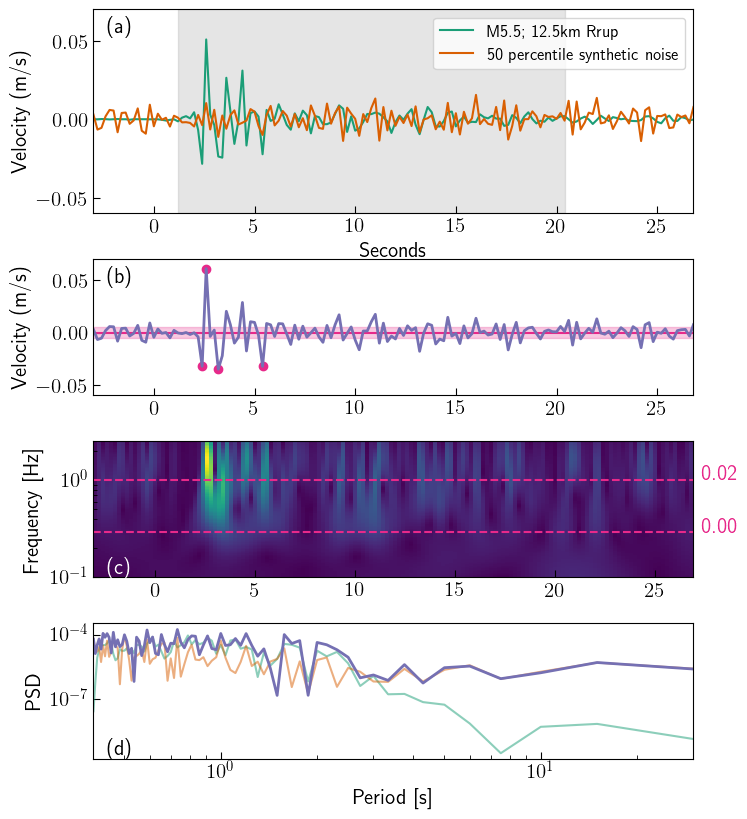

In [159]:
import matplotlib.gridspec as gridspec
import matplotlib.transforms as mtransforms
idx=60+150
idx2=idx+5*30

colors=['#1b9e77','#d95f02','#7570b3','#e7298a']
ax_lim=[-.06,.07]
axx_lim=[vel_1.time[idx:idx2].min(),vel_1.time[idx:idx2].max()]
trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)

fig = plt.figure(tight_layout=True, figsize=(8,10))
gs = gridspec.GridSpec(4, 3, height_ratios=(1.5,1, 1,1),
                      left=0.1, right=0.85, bottom=0.15, top=0.9,
                      wspace=0.05, hspace=0.3)


ax = fig.add_subplot(gs[0, :])

ax.axvspan(vel_1.time[vel_1.H0_y>0].min(),vel_1.time[vel_1.H0_y>0].max(), color='grey', alpha=.2)
ax.plot(vel_1.time[idx:idx2],vel_1.H0[idx:idx2], label='M5.5; 12.5km Rrup', color=colors[0])

ax.plot(vel_1.time[idx:idx2],noise_ts[idx:idx2], label='50 percentile synthetic noise', color=colors[1])
ax.set_ylim(ax_lim)
ax.legend()
ax.set_xlim(axx_lim)
ax.text(0, 1.0, '(a)', transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top')
ax.set_xlabel('Seconds')
ax.set_ylabel('Velocity (m/s)')

ax2 = fig.add_subplot(gs[1, :])
combined=vel_1.H0+noise_ts


abs_comb=np.abs(combined)
idx_4=abs_comb.argsort()[-4:][::-1]
ax2.scatter(vel_1.time[idx_4],combined[idx_4], color=colors[3])
ax2.axhline(np.median(combined[idx:idx2]), color=colors[3])
#ax2.axhline(stats.median_abs_deviation(combined[idx:idx2]), color=colors[3])
ax2.fill_between(vel_1.time, -stats.median_abs_deviation(combined[idx:idx2]),
                 stats.median_abs_deviation(combined[idx:idx2]),color=colors[3], alpha=0.25)
ax2.plot(vel_1.time[idx:idx2],combined[idx:idx2], color=colors[2], lw=2)
ax2.set_ylim(ax_lim)
ax2.set_xlim(axx_lim)
ax2.text(0, 1.0, '(b)', transform=ax2.transAxes + trans,
            fontsize='medium', verticalalignment='top')
ax2.set_ylabel('Velocity (m/s)')
#ax3 = fig.add_subplot(gs[2, 0])
#ax3.plot(vel_1.time[idx:idx2],combined[idx:idx2])
#ax3.set_ylim(ax_lim)

ax4 = fig.add_subplot(gs[3, :])
f,p_sig=signal.periodogram(vel_1.H0[idx:idx2],fs=5)
f,p_noise=signal.periodogram(noise_ts[idx:idx2],fs=5)
f,p_comb=signal.periodogram(combined[idx:idx2],fs=5)
ax4.loglog(1/f, p_sig, label='signal', color=colors[0], alpha=.5)
ax4.loglog(1/f, p_noise, label='noise', color=colors[1], alpha=.5)
ax4.loglog(1/f, p_comb, label='combined', color=colors[2], lw=2)
ax4.set_xlim([per_min,per_max*3])
ax4.text(0, .2, '(d)', transform=ax4.transAxes + trans,
            fontsize='medium', verticalalignment='top')

ax4.set_ylabel('PSD ')
ax4.set_xlabel('Period [s]')
#ax4.plot(1/f[0:100], p_sig[0:100], 'ro-')


#ax4.set_ylim(ax_lim)

ax5 = fig.add_subplot(gs[2, :])
per_min=.4
per_max=10
f_min = 1/per_max
f_max = 1/per_min

dt=.2
scalogram = cwt(combined[idx:idx2], dt, 1, f_min, f_max)


x, y = np.meshgrid(
    vel_1.time[idx:idx2],
    np.logspace(np.log10(f_min), np.log10(f_max), scalogram.shape[0]))

#cmap=obspy_sequential
cmap=plt.get_cmap('viridis')
im=ax5.pcolormesh(x, y, np.abs(scalogram), cmap=cmap)#obspy_sequential)

ax5.axhline(y[71,:][0], color=colors[3], linestyle='--')
slice_max=np.real(scalogram[71,:].max())
ax5.text(axx_lim[1]+.5,y[71,:][0],"{:.2f}".format(slice_max), color=colors[3])

ax5.axhline(y[33,:][0], color=colors[3], linestyle='--')
slice_max=np.real(scalogram[33,:].max())
ax5.text(axx_lim[1]+.5,y[33,:][0],"{:.2f}".format(slice_max), color=colors[3])
#ax.set_xlabel("Time after %s [s]" % tr.stats.starttime)
ax5.set_ylabel("Frequency [Hz]")
#ax[i,3].set_xlabel("Time since OT [S]")
#fig.colorbar(im, ax=ax5)
ax5.set_yscale('log')
ax5.set_ylim(f_min, f_max)
ax5.text(0, .2, '(c)', transform=ax5.transAxes + trans,
            fontsize='medium', verticalalignment='top', color='white')

plt.savefig('demonstrate.png',dpi=300)
#plt.savefig('figs/feature_peformance.png',dpi=300)

(0.015055720539667495+0.0097774062126580186j)

/home/ec2-user/miniconda3/envs/snivel/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


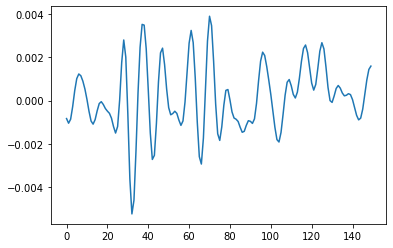

In [97]:
plt.plot(scalogram[30,:])


0.29240177382128651

array([  1.17379085e-02,   7.43581759e-03,   3.04504829e-03,
         6.93054930e-03,   3.69570317e-03,   1.19238222e-02,
         9.11949964e-03,   2.93224522e-03,   8.37888104e-03,
         5.81823037e-03,   9.63951049e-03,   3.78978195e-03,
         2.43597545e-03,   1.19806525e-02,   6.93116748e-03,
         1.35812950e-02,   2.13971337e-03,   2.20966102e-03,
         4.41106258e-03,   6.85122980e-04,   1.87652921e-03,
         3.58202040e-03,   2.36348299e-03,   2.21911311e-03,
         5.17321617e-04,   3.42426168e-03,   1.07628821e-02,
         7.81347782e-03,   3.00094087e-03,   4.43578747e-03,
         8.69965300e-04,   1.18424906e-02,   4.65813142e-03,
         7.77799794e-03,   4.94572572e-03,   2.96105696e-03,
         2.19191363e-03,   1.80241104e-03,   3.98341963e-03,
         8.68085965e-04,   1.66745024e-03,   5.58828702e-03,
         1.06192692e-03,   3.83054755e-03,   1.92369332e-03,
         1.65423660e-02,   1.06037325e-02,   6.37423469e-03,
         1.03041860e-02,

/tmp/ipykernel_22475/2604976490.py:29: RuntimeWarning: divide by zero encountered in log10
  acc_snr_db=20*np.log10(acc_snr)


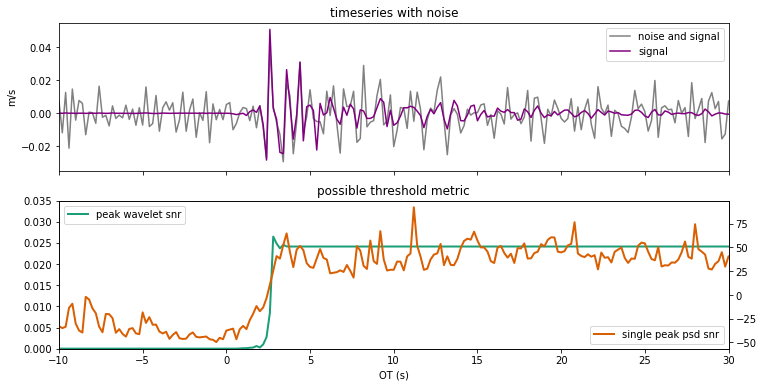

In [16]:
fig, ax=plt.subplots(2,1, figsize=(12,6),sharex=True)#,sharey=True, sharex=True)

#ax[0].axvline(first_t)
#ax[0].axvline(last_t)

for i,noise_lev in enumerate([90]):
    
    
    noise_ts=noise_ts_array[1]
    combined=vel_1.H0+noise_ts
    ax[0].plot(vel_1.time,combined, color='gray', label='noise and signal')
    ax[0].plot(vel_1.time,vel_1.H0, color='purple', label='signal')
    ax[0].set_title('timeseries with noise')
    ax[0].legend()
    snr_db_val=[]
    snr_t=[]
    snr_db_acc_val=[]
    snr_wavelet=[]
    for initial in np.arange(int(len(combined)-150)):
        
        #combined2=combined[initial:initial+1*(30*5)]
        #f,p=signal.periodogram(combined,fs=5)
        sig=vel_1.H0[initial:initial+1*(30*5)]
        noise=noise_ts[initial:initial+1*(30*5)]
        f_sig,p_sig=signal.periodogram(sig,fs=5)
        f_noi,p_noi=signal.periodogram(noise,fs=5)
        acc_snr=(p_sig[1:]/p_noi[1:])[1/f_sig[1:]>1].sum()
        acc_snr=(p_sig[1:]/p_noi[1:])[(p_sig[1:]/p_noi[1:])>1].sum()
        acc_snr_db=20*np.log10(acc_snr)
        snr_db_acc_val.append(acc_snr_db)
        
        #pk_bin=p_sig[1:].argmax()
        #snr_db=20*np.log10(p_sig[pk_bin]/p_noi[pk_bin])
        snr_db=20*np.log10(p_sig[1:]/p_noi[1:]).max()
        snr_db_val.append(snr_db)
        snr_t.append(vel_1.time[initial+1*(30*5)])
        
        
        per_min=.4
        per_max=10
        f_min = 1/per_max
        f_max = 1/per_min
        f = np.logspace(np.log10(f_min), np.log10(f_max), 100)
        w0=1
        scales=w0 / (2 * np.pi * f)
        
        #scalogram = cwt(sig, 1/5, 1, f_min, f_max)
        
        [sig_coefficients, frequencies] = pywt.cwt(sig, scales, 'morl', 5)
        [noise_coefficients, frequencies] = pywt.cwt(noise, scales, 'morl', 5)
        snr_wavelet.append(np.max((np.abs(sig_coefficients)-np.abs(noise_coefficients))))
        
        #np.abs(sig_coefficients).max(axis=1)
        

    snr_db_arr=np.array(snr_db_val)
    snr_t_arr=np.array(snr_t)
    snr_db_acc_arr=np.array(snr_db_acc_val)
    snr_wavelet_arr=np.array(snr_wavelet)
    
    #ax[i+1].plot(t_new2,combined)
    #ax[i+1].set_ylim(0,1)
    ax[i+1].plot(snr_t_arr,snr_wavelet_arr,  label='peak wavelet snr',color='#1b9e77', lw=2)
    ax[i+1].legend(loc='upper left')
    ax[i+1].set_ylim([0,.035])
    ax[i+1].set_title('possible threshold metric')
    
    ax2=ax[i+1].twinx()
    ax2.plot(snr_t_arr,snr_db_arr,  label='single peak psd snr', color='#d95f02', lw=2)
    #ax2.plot(snr_t_arr,snr_db_acc_arr, color='tab:green', label='accumulated positive snr')
    
    #ax2.set_ylim(-30,150)
    #ax2.set_ylim(-150,40)
    ax2.legend(loc='lower right')
    
ax[0].set_xlim([-10,30])
ax[0].set_ylabel('m/s')
ax[1].set_xlabel('OT (s)')

plt.savefig('wavelet_metric2.png', dpi=300)

In [13]:
#pk_bin=p_sig[1:].argmax()
#snr_db=20*np.log10(p_sig[pk_bin]/p_noi[pk_bin])
snr_db=20*np.log10(p_sig/p_noi).max()

In [14]:
snr_db

29.47422216281316

In [9]:
sig_coefficients

array([[ -1.18818202e-03,   1.32051444e-04,   2.04993903e-03, ...,
          8.63753391e-06,   6.23360183e-06,  -1.15967807e-05],
       [ -1.28007691e-03,   2.56025991e-04,   2.00714604e-03, ...,
          1.15639909e-05,   4.16800896e-06,  -1.30671118e-05],
       [ -4.37156025e-05,  -6.60939493e-04,   1.12262358e-03, ...,
         -2.56500517e-06,   4.57375610e-06,  -2.39344720e-06],
       ..., 
       [ -1.63131084e-08,   7.03102112e-09,   2.82194435e-08, ...,
         -3.04673074e-10,  -8.57198009e-12,  -5.42774829e-11],
       [ -1.60500213e-08,   6.91762939e-09,   2.77643387e-08, ...,
         -2.99759506e-10,  -8.43373678e-12,  -5.34021310e-11],
       [ -1.57912068e-08,   6.80607925e-09,   2.73166252e-08, ...,
         -2.94925738e-10,  -8.29773867e-12,  -5.25409956e-11]])

In [10]:
def plot_wavelet(time, signal, scales, 
                 waveletname = 'morl', 
                 cmap = plt.cm.jet, 
                 title = 'Wavelet Transform (Power Spectrum) of signal', 
                 ylabel = 'Period (Seconds)', 
                 xlabel = 'Time'):
    
    dt = time[1] - time[0]
    print(dt)
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    print(1/frequencies)
    print(len(time))
    print(len(coefficients))
    print(len(frequencies))
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log10(levels)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.contourf(time, np.log10(period), np.log10(power), extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log10(period.min())), np.ceil(np.log10(period.max())))
    ax.set_yticks(np.log10(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    #ax.set_ylim(ylim[0], -1)
    #ax.set_ylim(10e-1, 1/(20e0))
    
    #cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
    #fig.colorbar(im, cax=cbar_ax, orientation="vertical")
    plt.show()

In [ ]:
plot_wavelet(vel_1.time, combined, scales)

In [2]:
(1/2**0.5)*.5

0.35355339059327373